In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from system_ode_fedbatch import generate_data
from machinelearning_control_fedbatch import main, generate_dataset

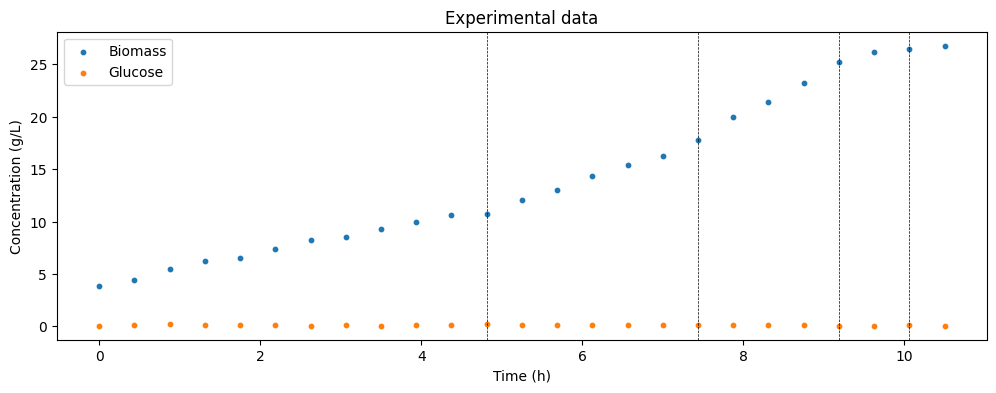

In [37]:
full_df = generate_data()

plt.figure(figsize=(12, 4))
plt.scatter(full_df['RTime'], full_df['Biomass'], s=10, label='Biomass')
plt.scatter(full_df['RTime'], full_df['Glucose'], s=10, label='Glucose')
for i in range(1, len(full_df)):
    if full_df["F"].iloc[i] != full_df["F"].iloc[i - 1]:
        plt.axvline(x=full_df["RTime"].iloc[i], color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.title('Experimental data')
plt.show()

In [38]:
# Get features and targets
in_train, out_train = generate_dataset(full_df)

Dataset shape: (300, 4)


In [39]:
# parameter values
mumax = 0.84     # 1/hour
Ks = 0.2          # g/liter
Yxs = 0.5         # g/g
Sin = 1.43 * 200  # g/liter

# initial conditions
t_start = full_df['RTime'].iloc[0]
t_end = full_df['RTime'].iloc[-1]
V0 = full_df['V'].iloc[0]
S0 = full_df['Glucose'].iloc[0]

In [40]:
net = main(in_train, out_train, t_start, t_end, Sin, S0, mumax, Ks, Yxs, verbose=10)

Epoch 0, Loss_data: 7.6013, Loss_ode: 2.9249
Epoch 10, Loss_data: 7.3590, Loss_ode: 2.2211
Epoch 20, Loss_data: 7.2584, Loss_ode: 2.4377
Epoch 30, Loss_data: 7.1698, Loss_ode: 2.1613
Epoch 40, Loss_data: 7.1229, Loss_ode: 1.6515
Epoch 50, Loss_data: 7.0808, Loss_ode: 1.4954
Epoch 60, Loss_data: 7.0102, Loss_ode: 1.4204
Epoch 70, Loss_data: 6.9116, Loss_ode: 1.4035
Epoch 80, Loss_data: 6.7899, Loss_ode: 1.3583
Epoch 90, Loss_data: 6.6410, Loss_ode: 1.3749
Epoch 100, Loss_data: 6.4699, Loss_ode: 1.3650
Epoch 110, Loss_data: 6.2439, Loss_ode: 1.3842
Epoch 120, Loss_data: 5.9533, Loss_ode: 1.3904
Epoch 130, Loss_data: 5.5770, Loss_ode: 1.3842
Epoch 140, Loss_data: 5.1004, Loss_ode: 1.4251
Epoch 150, Loss_data: 4.5125, Loss_ode: 1.4220
Epoch 160, Loss_data: 3.8196, Loss_ode: 1.4577
Epoch 170, Loss_data: 3.0433, Loss_ode: 1.4466
Epoch 180, Loss_data: 2.2317, Loss_ode: 1.4503
Epoch 190, Loss_data: 1.4680, Loss_ode: 1.5484
Epoch 200, Loss_data: 0.8409, Loss_ode: 1.5560
Epoch 210, Loss_data: 0.

KeyboardInterrupt: 

In [ ]:
# pickle save the model
import pickle
with open("pinc_model.pkl", "wb") as f:
    pickle.dump(net, f)

# Autoregression

In [ ]:
from machinelearning_control_fedbatch import numpy_to_tensor
import torch
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T_s = full_df['RTime'].iloc[1]
t_test = numpy_to_tensor(np.array([full_df["RTime"].values]))
X_test = numpy_to_tensor(np.array([full_df["Biomass"].values]))
S_test = numpy_to_tensor(np.array([full_df["Glucose"].values]))
F_test = numpy_to_tensor(np.array([full_df["F"].values]))
u_test = torch.cat([t_test, X_test, S_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test], dim=1)

In [ ]:
X_0 = X_test[0]
S_0 = S_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []
for i in range(len(u_test)):
    x_k = net.forward(torch.tensor([T_s, X_0, S_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())

In [ ]:
t_test = t_test.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()
S_test = S_test.detach().cpu().numpy()

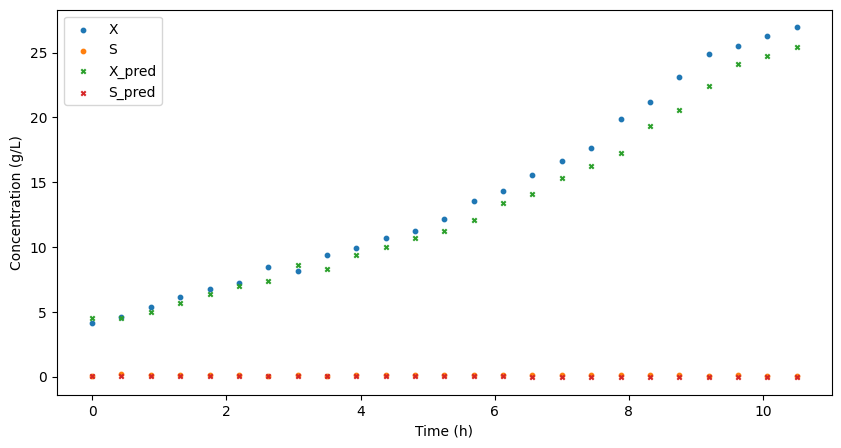

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(t_test, X_test, s=10, label="X")
plt.scatter(t_test, S_test, s=10, label="S")

plt.scatter(t_test, X_preds, s=10, marker='x', label="X_pred")
plt.scatter(t_test, S_preds, s=10, marker='x', label="S_pred")

plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.show()